# Análisis retrospectivo de la probabilidad de entrega de alta dosis en tratamientos de radioterapia IMRT para cáncer de mama
### Andrés Camilo Sevilla Moreno
14 de diciembre de 2020

Se importan las librerias o prerequisitos: <code>pydicom</code> para el procesamiento de imágenes en formato dicom (.dcm), <code>numpy</code> crear y operar arreglos de datos y <code>matplotlib</code> para construir gráficas. 

In [1]:
import pydicom
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dcmrtstruct2nii import dcmrtstruct2nii, list_rt_structs
import nibabel as nib
from scipy import ndimage

Se construye una función para evaluar una distribución normal centrada en cero (0) con desviación estándar <it>sigma</it> ($\sigma$) como parámetro. Esta función será utilizada para calcular el peso o la probabilidad asociada a la ocurrencia de un escenario de posicionamiento respecto al posicionamiento ideal.

In [2]:
sigma=5 # [mm]
def gaussian(x):
    return np.exp(-np.power(x, 2.) / (2 * np.power(sigma, 2.)))

Se carga la información del plan de radioterapia, específicamente se guarda en una variable la ubicación del isocentro para el plan nominal en [mm]

In [3]:
rtplan_file = '1758/Scen Nom/RP.1.3.6.1.4.1.2452.6.795765074.1307315126.1290677671.1371404822.dcm'
rtplan = pydicom.dcmread(rtplan_file)

isocenter = rtplan['BeamSequence'][0]['ControlPointSequence'][0]['IsocenterPosition'].value
print("Isocentro del plan de tratamiento nominal: ",isocenter)

Isocentro del plan de tratamiento nominal:  [89.01, -320.05, -1158.00]


Se lee la imágen de tomografía computarizada (ct) para el escenario nominal y se guarda en un arreglo de <code>numpy</code> de 3 dimensiones [x,y,z], los valores de intensidad se escalan de 0 a 255.

In [4]:
rtct = pydicom.dcmread('1758/Scen Nom/CT.1.3.12.2.1107.5.1.4.95340.30000018081413541135600000062.dcm')
ct_rows=rtct['Rows'].value
ct_columns=rtct['Columns'].value
ct = np.array(list(rtct['PixelData']))
ct = np.reshape(ct,(1,ct_rows,ct_columns,2))

Se encuentran los límites en [mm] de la tomografía considerando la coordenada (0,0) en el isocentro del plan nominal.

In [5]:
ct_rows=rtct['Rows'].value
ct_xPixelSize=rtct['PixelSpacing'][0]
ct_columns=rtct['Columns'].value
ct_yPixelSize=rtct['PixelSpacing'][1]
ct_center=np.zeros(3)
ct_center[0]=rtct['ImagePositionPatient'].value[0]+(ct_columns/2*ct_xPixelSize)
ct_center[1]=rtct['ImagePositionPatient'].value[1]+(ct_rows/2*ct_yPixelSize)
ct_xLimits=[-isocenter[0]+ct_center[0]-(ct_columns/2*ct_xPixelSize),-isocenter[0]+ct_center[0]+(ct_columns/2*ct_xPixelSize)]
ct_yLimits=[isocenter[1]-ct_center[1]-(ct_rows/2*ct_yPixelSize),isocenter[1]+-ct_center[1]+(ct_rows/2*ct_yPixelSize)]
ct_z=ct_center[2]

Se gráfica un corte de la tomografía considerando la coordenada (0,0) en el isocentro del plan nominal.

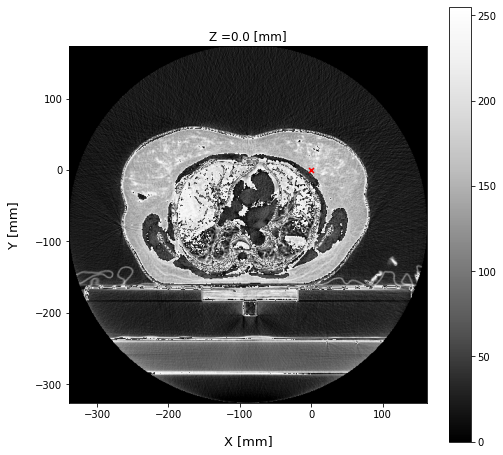

In [6]:
fig=plt.figure(figsize=(8,8))

ax1=fig.add_subplot(111)
ax1.set_title('Z ='+str(ct_z)+' [mm]')
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl1=ax1.scatter(0,0, marker='x', s=25, c='red')
pl1=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
plt.colorbar(pl1)

Se cargan las distribuciones de dosis para el escenario nominal y los múltiples escenarios de desplazamiento: 5 y 10 [mm] en los sentidos + y - en las direcciones x, y, z.

In [7]:
rtdose_file = []

rtdose_file.append('1758/Scen Nom/RD.1.3.6.1.4.1.2452.6.3774721829.1266769619.2049143469.630891650.dcm')

rtdose_file.append('1758/Scen 2-X/RD.1.3.6.1.4.1.2452.6.2574716406.1129645290.2045614210.4084810196.dcm')
rtdose_file.append('1758/Scen 3-X/RD.1.3.6.1.4.1.2452.6.729262367.1239407943.3491140261.2272738980.dcm')
rtdose_file.append('1758/Scen 4-X/RD.1.3.6.1.4.1.2452.6.2281195054.1320325393.1439287738.1821363235.dcm')
rtdose_file.append('1758/Scen 5-X/RD.1.3.6.1.4.1.2452.6.765389928.1257830913.4105408905.1881914643.dcm')

rtdose_file.append('1758/Scen 2-Y/RD.1.3.6.1.4.1.2452.6.776061810.1307110000.1928408509.1455643479.dcm')
rtdose_file.append('1758/Scen 3-Y/RD.1.3.6.1.4.1.2452.6.705780721.1202550084.1267710111.704293260.dcm')
rtdose_file.append('1758/Scen 4-Y/RD.1.3.6.1.4.1.2452.6.3080060196.1251630547.2218757517.3788265466.dcm')
rtdose_file.append('1758/Scen 5-Y/RD.1.3.6.1.4.1.2452.6.4191487010.1342139146.4151024575.537766042.dcm')

rtdose_file.append('1758/Scen 2-Z/RD.1.3.6.1.4.1.2452.6.1955838062.1317403300.1843011228.3585030968.dcm')
rtdose_file.append('1758/Scen 3-Z/RD.1.3.6.1.4.1.2452.6.1657963094.1129811739.1883553674.367995070.dcm')
rtdose_file.append('1758/Scen 4-Z/RD.1.3.6.1.4.1.2452.6.4267792804.1318291962.2688495806.2639844222.dcm')
rtdose_file.append('1758/Scen 5-Z/RD.1.3.6.1.4.1.2452.6.4027370827.1076642734.4051135664.3398967208.dcm')

rtdose = []
for i in range(np.size(rtdose_file)):
    rtdose.append(pydicom.dcmread(rtdose_file[i]))
    
pixel_data = []
dose = []

for i in range(np.size(rtdose)):
    pixel_data.append(np.array(list(rtdose[i]['PixelData'])))
    pixel_data[i]=np.reshape(pixel_data[i],(rtdose[i]['NumberOfFrames'].value, rtdose[i]['Rows'].value, rtdose[i]['Columns'].value,2))
    dose.append(pixel_data[i][:,:,:,1]*rtdose[i]['DoseGridScaling'].value)

Se guarda en un arreglo la magnitud de los desplazamientos del isocentro de cada escenario respecto al isocentro en el escenario nominal.

In [8]:
scen_shifting = [0,5,10,-5,-10,5,10,-5,-10,5,10,-5,-10] #[mm]

Se encuentran los límites en [mm] de la grilla de dosis considerando la coordenada (0,0) en el isocentro del plan nominal.

In [9]:
dose_rows=rtdose[0]['Rows'].value
dose_xPixelSize=rtdose[0]['PixelSpacing'][0]
dose_columns=rtdose[0]['Columns'].value
dose_yPixelSize=rtdose[0]['PixelSpacing'][1]
dose_center=np.zeros(3)
dose_center[0]=rtdose[0]['ImagePositionPatient'].value[0]+(dose_columns/2*dose_xPixelSize)
dose_center[1]=rtdose[0]['ImagePositionPatient'].value[1]+(dose_rows/2*dose_yPixelSize)

dose_xLimits=[-isocenter[0]+dose_center[0]-(dose_columns/2*dose_xPixelSize),-isocenter[0]+dose_center[0]+(dose_columns/2*dose_xPixelSize)]
dose_yLimits=[isocenter[1]-dose_center[1]-(dose_rows/2*dose_yPixelSize),isocenter[1]-dose_center[1]+(dose_rows/2*dose_yPixelSize)]

Se encuentra el número de corte de la distribución de dosis que corresponde con el isocentro del plan nominal.

In [10]:
dose_frameOffset = rtdose[0]['GridFrameOffsetVector'][1]-rtdose[0]['GridFrameOffsetVector'][0]
isocenter_slice=int((isocenter[2]-rtdose[0]['ImagePositionPatient'].value[2])/dose_frameOffset)
dose_slice=isocenter_slice

Se calcula el máximo de dosis para el numero de corte <code>dose_slice</code> en todos los escenarios.

In [11]:
d_max=np.max([dose[0][dose_slice,:,:].max(),dose[1][dose_slice,:,:].max(),dose[2][dose_slice,:,:].max(),dose[3][dose_slice,:,:].max(),dose[4][dose_slice,:,:].max(),dose[5][dose_slice,:,:].max(),dose[6][dose_slice,:,:].max(),dose[7][dose_slice,:,:].max(),dose[8][dose_slice,:,:].max(),dose[9][dose_slice,:,:].max(),dose[10][dose_slice,:,:].max(),dose[11][dose_slice,:,:].max(),dose[12][dose_slice,:,:].max()])

Se gráfica la distribución de dosis en todos los escenarios de desplazamiento en direcciones x,y,z.

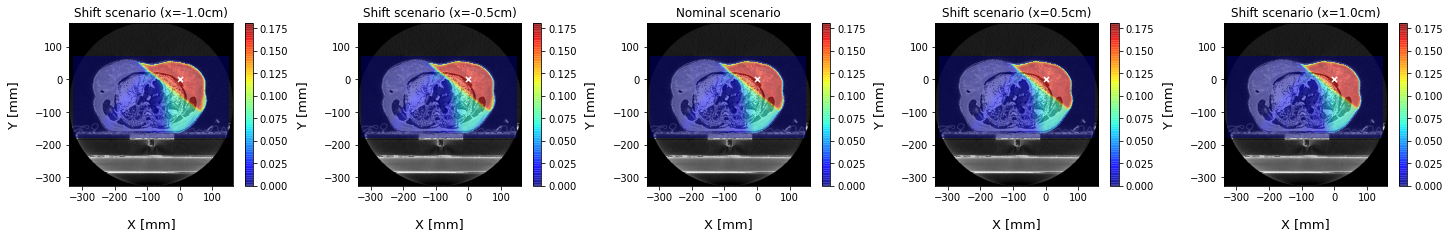

In [12]:
fig=plt.figure(figsize=(25,3))

ax1=fig.add_subplot(1,5,3)
ax1.set_title('Nominal scenario')
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl1=ax1.scatter(0,0, marker='x', s=25, c='white')
pl1=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl1=ax1.imshow(dose[0][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl1)

ax2=fig.add_subplot(1,5,4)
ax2.set_title('Shift scenario (x=0.5cm)')
ax2.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax2.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl2=ax2.scatter(0,0, marker='x', s=25, c='white')
pl2=ax2.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl2=ax2.imshow(dose[1][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl2)

ax3=fig.add_subplot(1,5,5)
ax3.set_title('Shift scenario (x=1.0cm)')
ax3.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax3.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl3=ax3.scatter(0,0, marker='x', s=25, c='white')
pl3=ax3.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl3=ax3.imshow(dose[2][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl3)

ax4=fig.add_subplot(1,5,2)
ax4.set_title('Shift scenario (x=-0.5cm)')
ax4.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax4.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl4=ax4.scatter(0,0, marker='x', s=25, c='white')
pl4=ax4.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl4=ax4.imshow(dose[3][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl4)

ax5=fig.add_subplot(1,5,1)
ax5.set_title('Shift scenario (x=-1.0cm)')
ax5.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax5.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl5=ax5.scatter(0,0, marker='x', s=25, c='white')
pl5=ax5.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl5=ax5.imshow(dose[4][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl5)

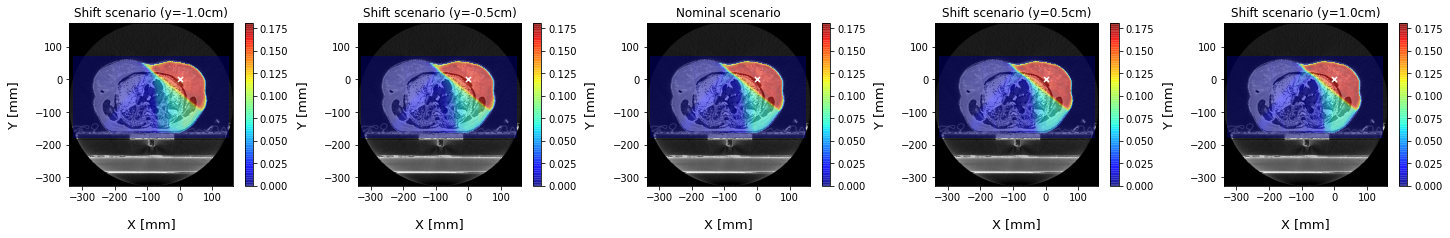

In [13]:
fig=plt.figure(figsize=(25,3))

ax1=fig.add_subplot(1,5,3)
ax1.set_title('Nominal scenario')
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl1=ax1.scatter(0,0, marker='x', s=25, c='white')
pl1=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl1=ax1.imshow(dose[0][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl1)

ax2=fig.add_subplot(1,5,4)
ax2.set_title('Shift scenario (y=0.5cm)')
ax2.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax2.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl2=ax2.scatter(0,0, marker='x', s=25, c='white')
pl2=ax2.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl2=ax2.imshow(dose[5][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl2)

ax3=fig.add_subplot(1,5,5)
ax3.set_title('Shift scenario (y=1.0cm)')
ax3.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax3.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl3=ax3.scatter(0,0, marker='x', s=25, c='white')
pl3=ax3.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl3=ax3.imshow(dose[6][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl3)

ax4=fig.add_subplot(1,5,2)
ax4.set_title('Shift scenario (y=-0.5cm)')
ax4.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax4.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl4=ax4.scatter(0,0, marker='x', s=25, c='white')
pl4=ax4.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl4=ax4.imshow(dose[7][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl4)

ax5=fig.add_subplot(1,5,1)
ax5.set_title('Shift scenario (y=-1.0cm)')
ax5.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax5.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl5=ax5.scatter(0,0, marker='x', s=25, c='white')
pl5=ax5.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl5=ax5.imshow(dose[8][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl5)

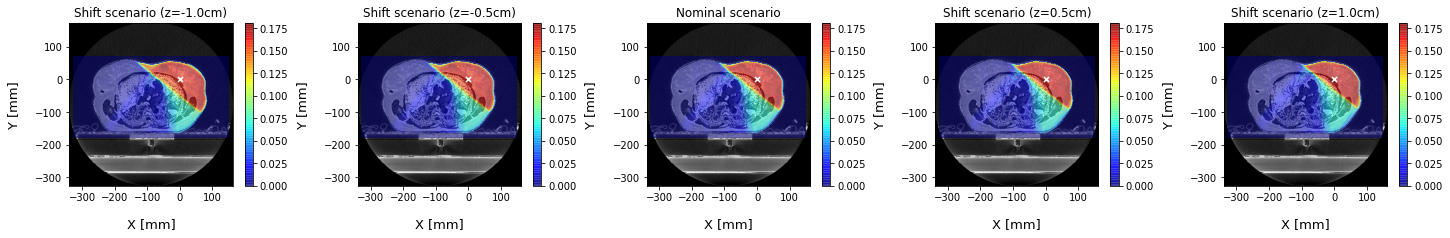

In [14]:
fig=plt.figure(figsize=(25,3))

ax1=fig.add_subplot(1,5,3)
ax1.set_title('Nominal scenario')
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl1=ax1.scatter(0,0, marker='x', s=25, c='white')
pl1=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl1=ax1.imshow(dose[0][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl1)

ax2=fig.add_subplot(1,5,4)
ax2.set_title('Shift scenario (z=0.5cm)')
ax2.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax2.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl2=ax2.scatter(0,0, marker='x', s=25, c='white')
pl2=ax2.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl2=ax2.imshow(dose[9][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl2)

ax3=fig.add_subplot(1,5,5)
ax3.set_title('Shift scenario (z=1.0cm)')
ax3.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax3.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl3=ax3.scatter(0,0, marker='x', s=25, c='white')
pl3=ax3.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl3=ax3.imshow(dose[10][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl3)

ax4=fig.add_subplot(1,5,2)
ax4.set_title('Shift scenario (z=-0.5cm)')
ax4.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax4.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl4=ax4.scatter(0,0, marker='x', s=25, c='white')
pl4=ax4.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl4=ax4.imshow(dose[11][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl4)

ax5=fig.add_subplot(1,5,1)
ax5.set_title('Shift scenario (z=-1.0cm)')
ax5.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax5.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl5=ax5.scatter(0,0, marker='x', s=25, c='white')
pl5=ax5.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl5=ax5.imshow(dose[12][dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl5)

Se calcula la distribución de dosis considerando incertidumbres aleatorias (en la ejecución del tratamiento) definidas por la desviación estándar ($\sigma$).

In [15]:
d_mean=(dose[0]*gaussian(scen_shifting[0])+dose[1]*gaussian(scen_shifting[1])+dose[2]*gaussian(scen_shifting[2])+dose[3]*gaussian(scen_shifting[3])+dose[4]*gaussian(scen_shifting[4])+dose[5]*gaussian(scen_shifting[5])+dose[6]*gaussian(scen_shifting[6])+dose[7]*gaussian(scen_shifting[7])+dose[8]*gaussian(scen_shifting[8])+dose[9]*gaussian(scen_shifting[9])+dose[10]*gaussian(scen_shifting[10])+dose[11]*gaussian(scen_shifting[11])+dose[12]*gaussian(scen_shifting[12]))\
/(gaussian(scen_shifting[0])+gaussian(scen_shifting[1])+gaussian(scen_shifting[2])+gaussian(scen_shifting[3])+gaussian(scen_shifting[4])+gaussian(scen_shifting[5])+gaussian(scen_shifting[6])+gaussian(scen_shifting[7])+gaussian(scen_shifting[8])+gaussian(scen_shifting[9])+gaussian(scen_shifting[10])+gaussian(scen_shifting[11])+gaussian(scen_shifting[12]))

Se grafica la distribución de dosis considerando incertidumbres aleatorias (en la ejecución del tratamiento) definidas por la desviación estándar ($\sigma$).

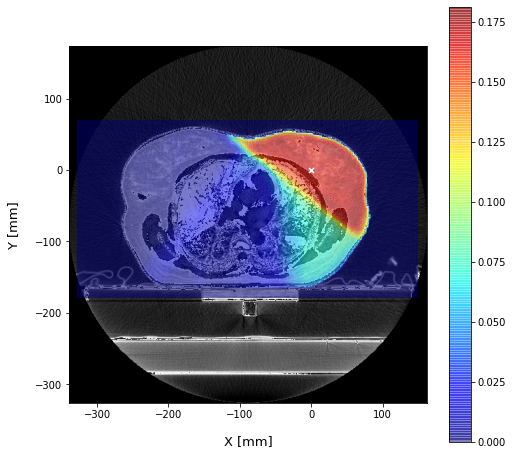

In [16]:
fig=plt.figure(figsize=(8,8))

ax1=fig.add_subplot(111)
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl=ax1.scatter(0,0, marker='x', s=25, c='white')
pl=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl=ax1.imshow(d_mean[dose_slice,:,:],vmin=0,vmax=d_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl)

Cálculo de la desviación estándar de la distribución de dosis en todos los escenarios respecto a la dosis considerando incertidumbres aleatorias

In [17]:
d_error=pow((pow(dose[0]-d_mean,2)*gaussian(scen_shifting[0])+pow(dose[1]-d_mean,2)*gaussian(scen_shifting[1])+pow(dose[2]-d_mean,2)*gaussian(scen_shifting[2])+pow(dose[3]-d_mean,2)*gaussian(scen_shifting[3])+pow(dose[4]-d_mean,2)*gaussian(scen_shifting[4])+pow(dose[5]-d_mean,2)*gaussian(scen_shifting[5])+pow(dose[6]-d_mean,2)*gaussian(scen_shifting[6])+pow(dose[7]-d_mean,2)*gaussian(scen_shifting[7])+pow(dose[8]-d_mean,2)*gaussian(scen_shifting[8])+pow(dose[9]-d_mean,2)*gaussian(scen_shifting[9])+pow(dose[10]-d_mean,2)*gaussian(scen_shifting[10])+pow(dose[11]-d_mean,2)*gaussian(scen_shifting[11])+pow(dose[12]-d_mean,2)*gaussian(scen_shifting[12]))\
            /(gaussian(scen_shifting[0])+gaussian(scen_shifting[1])+gaussian(scen_shifting[2])+gaussian(scen_shifting[3])+gaussian(scen_shifting[4])+gaussian(scen_shifting[5])+gaussian(scen_shifting[6])+gaussian(scen_shifting[7])+gaussian(scen_shifting[8])+gaussian(scen_shifting[9])+gaussian(scen_shifting[10])+gaussian(scen_shifting[11])+gaussian(scen_shifting[12])),0.5)

Cálculo del valor máximo de desviación estándar de la distribución de dosis

In [18]:
error_max=d_error[dose_slice,:,:].max();

Se grafica la desviación estándar de la distribución de dosis en todos los escenarios respecto a la dosis considerando incertidumbres aleatorias

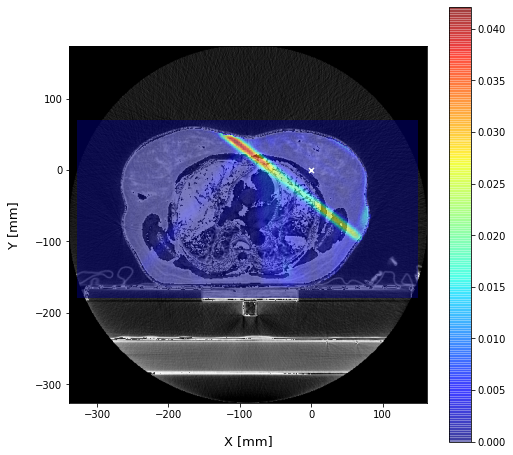

In [20]:
fig=plt.figure(figsize=(8,8))

ax1=fig.add_subplot(111)
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl=ax1.scatter(0,0, marker='x', s=25, c='white')
pl=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl=ax1.imshow(d_error[dose_slice,:,:],vmin=0,vmax=error_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl)

Cálculo de la desviación estándar de la distribución de dosis en todos los escenarios respecto a la dosis en el escenario nominal

In [22]:
d2_error=pow((pow(dose[0]-dose[0],2)*gaussian(scen_shifting[0])+pow(dose[1]-dose[0],2)*gaussian(scen_shifting[1])+pow(dose[2]-dose[0],2)*gaussian(scen_shifting[2])+pow(dose[3]-dose[0],2)*gaussian(scen_shifting[3])+pow(dose[4]-dose[0],2)*gaussian(scen_shifting[4])+pow(dose[5]-dose[0],2)*gaussian(scen_shifting[5])+pow(dose[6]-dose[0],2)*gaussian(scen_shifting[6])+pow(dose[7]-dose[0],2)*gaussian(scen_shifting[7])+pow(dose[8]-dose[0],2)*gaussian(scen_shifting[8])+pow(dose[9]-dose[0],2)*gaussian(scen_shifting[9])+pow(dose[10]-dose[0],2)*gaussian(scen_shifting[10])+pow(dose[11]-dose[0],2)*gaussian(scen_shifting[11])+pow(dose[12]-dose[0],2)*gaussian(scen_shifting[12]))\
            /(gaussian(scen_shifting[0])+gaussian(scen_shifting[1])+gaussian(scen_shifting[2])+gaussian(scen_shifting[3])+gaussian(scen_shifting[4])+gaussian(scen_shifting[5])+gaussian(scen_shifting[6])+gaussian(scen_shifting[7])+gaussian(scen_shifting[8])+gaussian(scen_shifting[9])+gaussian(scen_shifting[10])+gaussian(scen_shifting[11])+gaussian(scen_shifting[12])),0.5)

Cálculo del valor máximo de desviación estándar de la distribución de dosis

In [27]:
d2_error_max=d2_error[dose_slice,:,:].max();

Se grafica la desviación estándar de la distribución de dosis en todos los escenarios respecto a la dosis en el escenario nominal

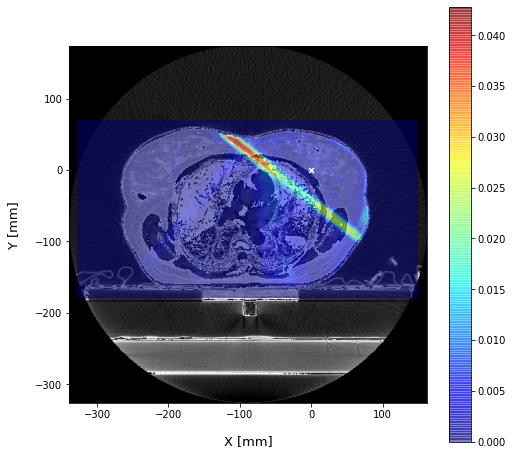

In [28]:
fig=plt.figure(figsize=(8,8))

ax1=fig.add_subplot(111)
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl=ax1.scatter(0,0, marker='x', s=25, c='white')
pl=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1.0,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl=ax1.imshow(d2_error[dose_slice,:,:],vmin=0,vmax=d2_error_max, cmap='jet',alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl)

Se imprime la lista de las estructuras definidas para el plan de tratamiento.

In [29]:
print(list_rt_structs('1758/Scen Nom/RS.1.3.6.1.4.1.2452.6.2980964693.1161016514.1454204820.428454200.dcm'))

['ORIGEN', 'EXTERNAL', 'PULMON DER', 'PULMON IZQ', 'CORAZON', 'SENO CONTRALATERAL', 'CTV', 'PTV']


Se lee conjunto de estructuras definidas para el plan de tratamiento y se exportan en formato .nii

In [36]:
dcmrtstruct2nii('1758/Scen Nom/RS.1.3.6.1.4.1.2452.6.2980964693.1161016514.1454204820.428454200.dcm', '1758/Scen Nom','1758/Scen Nom/extracted')

Se lee el archivo de correspondiente al CTV y se construye una máscara a partir de esta estructura. 

In [37]:
img1 = nib.load('1758/Scen Nom/extracted/mask_CTV.nii.gz')
struct_data = img1.get_fdata()
mask = (struct_data.transpose(2,1,0)/struct_data.max())

Se gráfica el corte axial de la máscara del CTV en el isocentro del plan de tratamiento nominal.

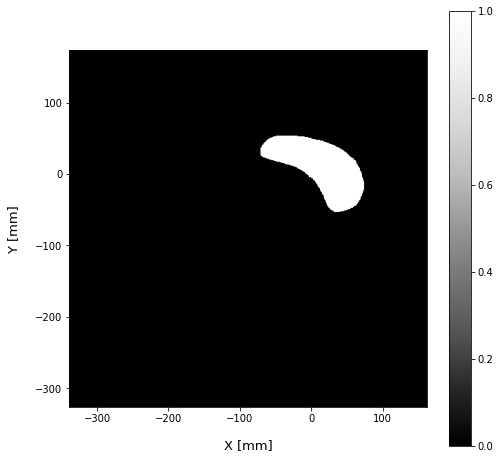

In [32]:
fig=plt.figure(figsize=(8,8))

ax1=fig.add_subplot(111)
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl=ax1.scatter(0,0, marker='x', s=25, c='white')
pl=ax1.imshow(mask[dose_slice,:,:], cmap='Greys_r',extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
plt.colorbar(pl)

Se define la magnitud del factor de remuestreo de la máscara de la estructura para hacerla corresponder con la grilla de dosis e incertidumbre

In [38]:
mask_xResampling = ct_xPixelSize/dose_xPixelSize
mask_yResampling = ct_yPixelSize/dose_yPixelSize
mask_zResampling = 1

d2_error_masked=(ndimage.zoom(mask,[mask_zResampling,mask_xResampling,mask_yResampling])[:,42:125,4:163])*d2_error[:,:,:]

Se grafica la desviación estándar de la distribución de dosis en todos los escenarios respecto a la dosis en el escenario nominal, filtrada para el CTV

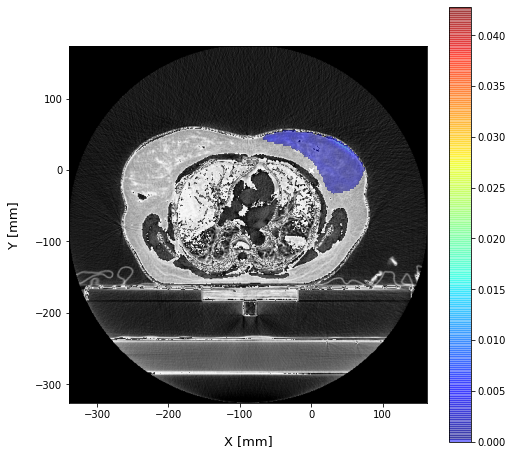

In [34]:
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0, 0, 1, .0)
levels=200
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, levels)

fig=plt.figure(figsize=(8,8))

ax1=fig.add_subplot(111)
ax1.set_xlabel('X [mm]', fontsize=13,labelpad=15)
ax1.set_ylabel('Y [mm]', fontsize=13,labelpad=15)
pl=ax1.scatter(0,0, marker='x', s=25, c='white')
pl=ax1.imshow(ct[0,:,:,0],vmin=0,vmax=255,cmap='Greys_r',alpha=1,extent=[ct_xLimits[0],ct_xLimits[1],ct_yLimits[0],ct_yLimits[1]])
pl=ax1.imshow(d2_error_masked[dose_slice,:,:],vmin=0,vmax=d2_error_max, cmap=cmap,alpha=0.5,extent=[dose_xLimits[0],dose_xLimits[1],dose_yLimits[0],dose_yLimits[1]])
plt.colorbar(pl)

Se calcula el máximo de la distribución de incertidumbre en el CTV

In [35]:
print("Valor máximo de incertidumbre (CTV): ",d2_error_masked.max(),"[Gy]")

Valor máximo de incertidumbre (CTV):  0.01346960285460393 [Gy]
